<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels_RF_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random forest model

## Installing necessary functions

In [ ]:
%pip install mahotas
%pip install Augmentor
%pip install split-folders tqdm
%pip uninstall -y numpy #these 4 lines were added because of an error with loading the LabelEncoder
%pip uninstall -y setuptools
%pip uninstall -y scikit-learn
%pip install numpy
%pip install scikit-learn #need newest updat of sklearn for certain evaluation metrics
%pip install setuptools
#don't forget to click restart runtime here!

In [ ]:
import itertools
import numpy as np
import mahotas
import cv2
import os
import matplotlib.pyplot as plt
import Augmentor
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from google.colab import files
import shutil
from sklearn.model_selection import GridSearchCV
import re
import splitfolders
from sklearn import metrics
from math import copysign
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Creating functions for later use

### Features extraction

In [ ]:
# FUNCTION TO CALCULATE LEARNABLE FEATURES IN IMAGES


# features description -1:  Hu Moments
def fd_hu_moments(image):
    #thresholding with geen pixel mask
    blue, green, red = cv2.split(image)
    basic=(blue<65) & (green>80)
    dark= (blue<40) & (green>35) & (red <45)
    lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
    lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
    newimg=basic+dark+lightvery+lightmedium
    thres = np.multiply(newimg, 1, dtype='uint8' )
    #Hu moments
    feature = cv2.HuMoments(cv2.moments(thres)).flatten()
    for i in range(0,7):
      if feature[i] !=0:
        feature[i] = -1* copysign(1.0, feature[i]) * np.log10(abs(feature[i]))
    return feature

# feature-descriptor -2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-description -3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COMPUTE THE COLOR HISTOGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[8,8,8], [0, 180, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histogram
    return hist.flatten()

#feature-description -4: sum green pixels as feature
def fd_greenpixels(image):
  #First green counter
  blue, green, red = cv2.split(image)
  basic=(blue<65) & (green>80)
  dark= (blue<40) & (green>35) & (red <45)
  lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
  lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
  newimg=basic+dark+lightvery+lightmedium
  sumpixels=newimg.sum()
  #Second green counter
  newimg2 = (green>(blue+20))&(green>(red+15))
  sumpixels2 = newimg2.sum()
  return sumpixels, sumpixels2

#feature-description -5: sum green pixels as feature
def fd_vegindices(image): #these come from https://isprs-archives.copernicus.org/articles/XLII-3/1215/2018/isprs-archives-XLII-3-1215-2018.pdf
#   this paper also uses these: https://www.sciencedirect.com/science/article/pii/S1470160X16301406?casa_token=8wIIrswmqc8AAAAA:tr0iQCh7kW4ZjbWMLckAAPwQpYsF2GFS3ERnglxFSrYd8C8-WVuREf83BPYjv391ZAlpsz9mPFY
  blue, green, red = cv2.split(image)
  RGBVI = (np.multiply(green, green, dtype=np.uint32) - np.multiply(red, blue, dtype=np.uint32))/(np.multiply(green, green, dtype=np.uint32)+np.multiply(red, blue,dtype=np.uint32 ))
  GLI = ((np.multiply(green,2,dtype=np.uint16 ) - red - blue)/(np.multiply(green,2,dtype=np.uint16 ) +red+blue))
  VARI = ((green-red)/(np.add(red, green, dtype = np.uint16)-blue))
  NGRDI = ((green-red)/(np.add(red, green, dtype = np.uint16)))
  combo = [np.mean(RGBVI), np.mean(GLI), np.mean(VARI), np.mean(NGRDI)]
  return combo

### Creating directory

In [ ]:
def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
          os.makedirs(path)

### Oversampling

In [ ]:
#Function to generate extra data by oversampling
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages
        seed = random.randint(0, 1000)

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print ("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.set_seed(seed)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False)


## Data preprocessing

### Setting directories

In [ ]:
main_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Train'#NewClips
split_path= '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split'
train_path = split_path + "/train"
val_path = split_path + "/val"
oversample_path="/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/OversampleRegression"
output_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputRF'

### Reading in data

In [ ]:
#reading in the y data
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
DMY = Dataset_multigras['DMY (kg/ha)']
DMY_int=[]
for i in range(0,len(DMY)):
   try: DMY_int.append(int(DMY[i]))
   except ValueError: DMY_int.append(-544)

### Creating paths and oversampling

In [ ]:
#setting up model directory
#split folder verwijderen
!rm -rf '{split_path}'
#regression folder verwijderen
!rm -rf '{oversample_path}'
#output folder verwijderen en opnieuw aanmaken
!rm -rf '{output_path}'
makedir(output_path)
#Nieuwe split doen op de folders
splitfolders.ratio(main_path, output=split_path, seed=42, ratio=(0.8, 0.2), group_prefix=None, move=False)

Copying files: 3772 files [03:20, 18.81 files/s]


In [ ]:
# #oversample
# target_dir = train_path
# dir=target_dir
# makedir(target_dir)
# folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
# target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
# oversample_func(split_path,  folders, target_folders, 1360)

saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep
Initialised with 297 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep.

Processing BLOK1R20P1.png: 100%|██████████| 1063/1063 [00:24<00:00, 42.90 Samples/s]


### Feature extracting and combining with DM values

In [ ]:
#creating datasets
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
features_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each training folder
  dir = os.path.join(train_path, training_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= int(DMY[index])
    except ValueError:y=-1

    file = dir + "/" + os.fsdecode(file)
    # read the image and compute features
    image = cv2.imread(file)

    image = cv2.resize(image, tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)


    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

    # update the list of labels and feature vectors
    if (y>0):
      y_values_train.append(y)
      features_train.append(global_feature)

print("Completed Training Set Feature Extraction...")

# get the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()

# empty list to hold feature vectors and labels
features_val = []
y_values_val = []
# loop over the validation data sub folder

for val_name in val_labels:
  # join the validation data path and each validation folder
  dir = os.path.join(val_path, val_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
      RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
      BlokRowCol=re.findall(r'\d+', RowCol_string[0])
      Blok=int(BlokRowCol[0])
      Row=int(BlokRowCol[1])
      Col=int(BlokRowCol[2])
      index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
      try:y= int(DMY[index])
      except ValueError:y=-1
      file = dir + "/" + os.fsdecode(file)

      # read the image and compute features
      image = cv2.imread(file)

      if image is not None:
          image = cv2.resize(image, tuple((51, 51)))
          fv_hu_moments = fd_hu_moments(image)
          fv_haralick   = fd_haralick(image)
          fv_histogram  = fd_histogram(image)
          fv_greenpixels= fd_greenpixels(image)
          fv_vegindices = fd_vegindices(image)

      # Concatenate global features
      global_val_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

      # update the list of labels and feature vectors
      if (y>0):
        y_values_val.append(y)
        features_val.append(global_val_feature)


print("Completed Validation Set Feature Extraction...")

#creating datasets
#creating X datasets
X_train=np.array(features_train)
X_val=np.array(features_val)

#creating y datasets
y_train =y_values_train
y_val = y_values_val

Completed Training Set Feature Extraction...
Completed Validation Set Feature Extraction...


## Creating and tuning the model

In [ ]:
# #creating the model and hyperparameter tuning
# forest  = RandomForestRegressor(n_estimators=250, max_features=1/3) #max features is the amount of features for each split
# parameter_grid_forest = {
#  #'absolute_error', 'friedman_mse', 'poisson'
#   "max_depth": [3,5,7],
#   "ccp_alpha": np.logspace(-3, 0, 5)
#   }
# grid_forest = GridSearchCV(forest, parameter_grid_forest)
# grid_forest.fit(X_train,y_train)
# print('The best parameters are: {}'.format(grid_forest.best_params_))

The best parameters are: {'ccp_alpha': 0.005623413251903491, 'max_depth': 7}


In [ ]:
#testing the optimized model
forest_opt= RandomForestRegressor(n_estimators=1000, max_features = 1/3) #, max_features = 1/3
forest_opt.fit(X_train, y_train)
print(forest_opt.score(X_train, y_train))
print(forest_opt.score(X_val,y_val))
Y_pred=forest_opt.predict(X_val)
print(metrics.root_mean_squared_error(y_val, Y_pred))

0.9450042129354802
0.6226004836133051
1337.862628787744


## Feature selection

In [ ]:
#feature selection
#selection with mean
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000, max_features = 1/3 ), threshold='mean') #, max_features = 1/3
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(selected_feat)
print(len(selected_feat))


X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
print("R2 train {:.4f} ".format(forest_opt.score(X_train_selected, y_train)))
print("R2 val {:.4f} ".format(forest_opt.score(X_val_selected,y_val)))
Y_pred_val=forest_opt.predict(X_val_selected)
print("RMSE {:.4f}".format(metrics.root_mean_squared_error(y_val, Y_pred)))

Index([  2,   3,   4,   9,  10,  11,  65,  66,  67,  68,  73,  74,  75,  76,
        77,  81,  82,  83,  84,  90,  91, 129, 130, 131, 132, 137, 138, 139,
       140, 141, 145, 146, 147, 148, 149, 153, 154, 155, 156, 161, 162, 163,
       164, 169, 170, 171, 177, 178, 179, 185, 186, 204, 512, 513, 514, 515,
       516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529,
       530, 531, 532, 533, 534, 535, 536, 537],
      dtype='int64')
78
R2 train 0.9448 
R2 val 0.6301 
RMSE 1309.8338


In [ ]:
#feature selection
#selection with 0.01
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000, max_features = 1/3 ), threshold=0.01) #, max_features = 1/3
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(selected_feat)
print(len(selected_feat))


X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
print("R2 train {:.4f} ".format(forest_opt.score(X_train_selected, y_train)))
print("R2 val {:.4f} ".format(forest_opt.score(X_val_selected,y_val)))
Y_pred_val=forest_opt.predict(X_val_selected)
print("RMSE {:.4f}".format(metrics.root_mean_squared_error(y_val, Y_pred)))

Index([67, 169, 170, 177, 178, 514, 523, 524, 532, 533], dtype='int64')
10
R2 train 0.9424 
R2 val 0.6133 
RMSE 1309.8338


['Green Pixels too lenient', 'Green Pixels too strict', 'Colour Histogram 68', 'Hu Moments 4', 'Colour Histogram 4', 'Hu Moments 1', 'Colour Histogram 178', 'VARI', 'Haralick Texture 12', 'Haralick Texture 13', 'Haralick Texture 3', 'Colour Histogram 179', 'RGBVI', 'Colour Histogram 171', 'GLI']
Green Pixels too lenient    0.202931
Green Pixels too strict     0.138143
Colour Histogram 68         0.053319
Hu Moments 4                0.035307
Colour Histogram 4          0.031592
Hu Moments 1                0.030877
Colour Histogram 178        0.019489
VARI                        0.018030
Haralick Texture 12         0.017221
Haralick Texture 13         0.015531
Haralick Texture 3          0.014859
Colour Histogram 179        0.013771
RGBVI                       0.012505
Colour Histogram 171        0.011758
GLI                         0.011370
dtype: float64


Text(0.5, 1.0, 'RF_regression_382')

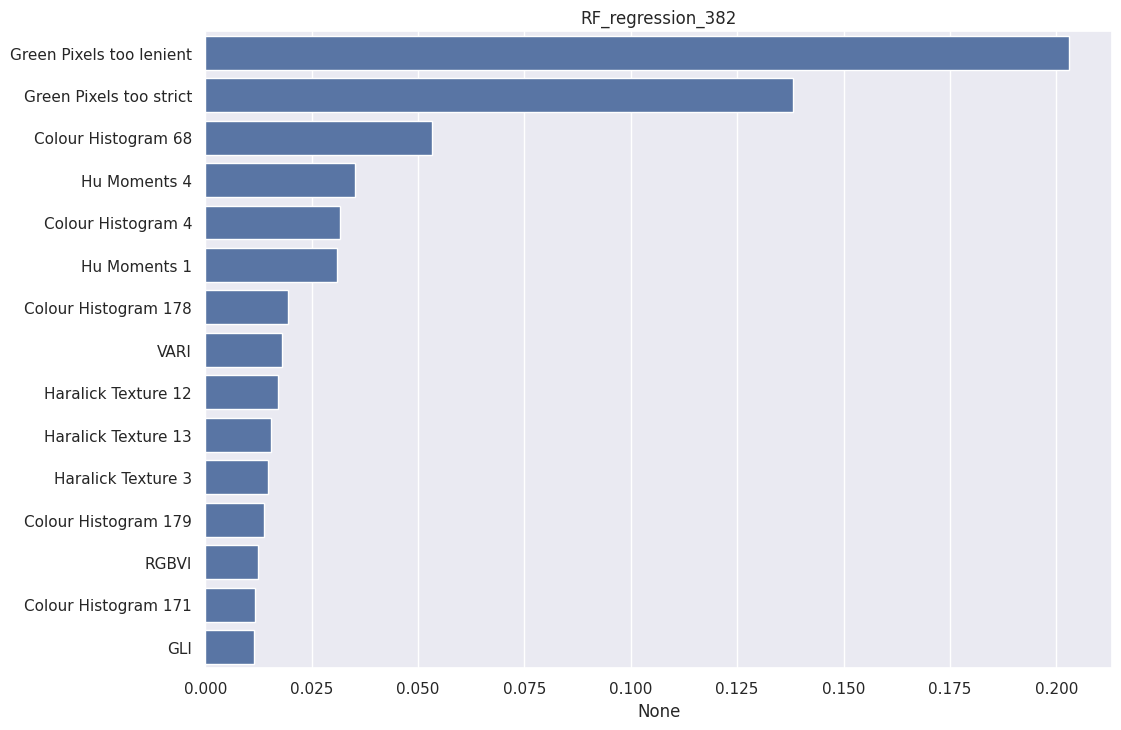

In [ ]:
# Representing feature importance
#names
histo_names = [f"Colour Histogram {i}" for i in range(1,513)]
haralick_names = [f"Haralick Texture {i}" for i in range(1,14)]
Hu_names = [f"Hu Moments {i}" for i in range(1,8)]
Greenpix_names = ['Green Pixels too strict', 'Green Pixels too lenient']
Veg_names = ['RGBVI', 'GLI', 'VARI', 'NGRDI']
feature_names = histo_names + haralick_names + Hu_names + Greenpix_names + Veg_names
feature_names_pd = pd.DataFrame(data=feature_names)
#importances
forest_opt= RandomForestRegressor(n_estimators = 1000, max_features = 1/3)#, max_features = 1/3
forest_opt.fit(X_train, y_train)
importances = forest_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_opt.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
sorted_indices = forest_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = forest_importances[sorted_indices]
Important_feat_names = sorted_feature_names[0:15]
Important_feat_importance = sorted_importances[0:15]

print(Important_feat_names)
print(Important_feat_importance)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=Important_feat_importance, y=Important_feat_names)
plt.title('RF_regression_382')

## Testing optimal model

In [ ]:
#importing test set
test_path = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test'

In [ ]:
#Extracting features and combining with DMY values test set
#creating datasets
# read the test data labels
test_labels = os.listdir(test_path)
# sort the test labesl
test_labels.sort()
# empty list to hold feature vectors and labels
features_test = []
y_values_test = []

# loop over the test data sub folder
for test_name in test_labels:
  # join the test data path and each species test folder
  dir = os.path.join(test_path, test_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= int(DMY[index])
    except ValueError:y=-1

    file = dir + "/" + os.fsdecode(file)
    # read the image and compute features
    image = cv2.imread(file)

    image = cv2.resize(image,tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

    # update the list of labels and feature vectors
    if (y>0):
      y_values_test.append(y)
      features_test.append(global_feature)

print("Completed Test Set Feature Extraction...")

#creating datasets
X_test=np.array(features_test)
y_test = y_values_test

#Combining train and validation set to use both as a train set for the final model
X_train_full = np.vstack((X_train,X_val))
y_train_full = np.hstack((y_train, y_val))

Completed Test Set Feature Extraction...


Train R2 0.9464 
Test R2 0.5930 
Test RMSE 1452.1799 


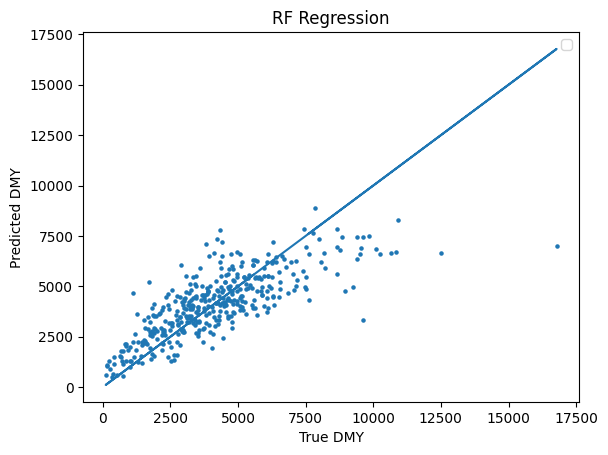

In [ ]:
#Training and testing model
forest_opt= RandomForestRegressor(n_estimators=1000, max_features = 1/3)
forest_opt.fit(X_train_full, y_train_full)

print("Train R2 {:.4f} ".format(forest_opt.score(X_train_full, y_train_full)))
print("Test R2 {:.4f} ".format(forest_opt.score(X_test,y_test)))
Y_pred=forest_opt.predict(X_test)
print("Test RMSE {:.4f} ".format(metrics.root_mean_squared_error(y_test, Y_pred)))
Y_pred=forest_opt.predict(X_test)
plt.scatter(y_test, Y_pred,s = 5)
plt.plot(y_test, y_test)
plt.xlabel('True DMY')
plt.ylabel('Predicted DMY')
plt.title('RF Regression')
plt.show()